# Validación y Optimización del Agente MCTS para Connect-4

Este notebook/markdown contiene todo lo necesario para validar y medir métricas del agente MCTS que tienes en el repositorio. Está preparado para ejecutarse en un Jupyter notebook (o un entorno que ejecute celdas de Python). He corregido y robustecido las importaciones y funciones para que funcione aun cuando la `MCTSPolicy` esté en un archivo `policy.py` dentro del repo en alguna carpeta.

Instrucciones rápidas:
- Ejecuta esto desde la raíz del repositorio (donde está la carpeta `tournament`).
- Si tu `MCTSPolicy` está en un archivo `policy.py` en algún subdirectorio, el script intentará encontrarlo automáticamente y cargarlo.
- Si prefieres, puedes copiar el archivo `policy.py` con la clase `MCTSPolicy` a `tournament/groups/YourGroup/policy.py` y el loader lo detectará.

---

## 0. Notas de diseño y cambios respecto al notebook original

- Se añade manejo dinámico para localizar e importar `MCTSPolicy` (busca archivos que contengan `class MCTSPolicy`).
- Se asegura que `connect4` sea importable añadiendo `tournament/` al `sys.path`.
- `play_game` ahora registra qué jugador hizo cada movimiento para asociar tiempos correctamente.
- Las funciones y visualizaciones están organizadas en secciones reproducibles.
- Todas las dependencias estándar se usan: numpy, matplotlib, seaborn, tqdm, pandas. Asegúrate de tenerlas instaladas.

---

## 1 — Setup e imports

In [3]:
# 1. Setup e imports
import sys
from pathlib import Path
import importlib.util
import importlib.machinery
import inspect
import re

import time
from collections import defaultdict
from typing import List, Tuple, Dict

# Ejecuta esto en una celda con "!" o en tu terminal
!pip install --upgrade pip
!pip install numpy matplotlib seaborn tqdm pandas

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Para notebooks
%matplotlib inline

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Asegurarnos de que 'tournament' esté en sys.path para importar el paquete connect4
ROOT = Path.cwd()
TOURNAMENT = ROOT / "tournament"
if str(TOURNAMENT) not in sys.path:
    sys.path.insert(0, str(TOURNAMENT))

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\User\miniconda3\envs\sparkoperaciones\python.exe -m pip install --upgrade pip


---

## 2 — Localizar e importar MCTSPolicy dinámicamente

Este bloque busca archivos `policy.py` en el repo que contengan la definición `class MCTSPolicy` y lo carga como módulo. Si la clase ya está en `connect4` o en alguna ruta conocida, se intentará usar esa.

In [4]:
# 2. Buscar e importar MCTSPolicy automáticamente (busca 'class MCTSPolicy' en policy.py)
def find_mcts_policy():
    # Buscar archivos policy.py dentro de tournament/
    candidates = list(TOURNAMENT.rglob("policy.py"))
    for p in candidates:
        try:
            text = p.read_text(encoding="utf-8")
        except Exception:
            continue
        if re.search(r"class\s+MCTSPolicy\b", text):
            return p
    return None

mcts_policy_path = find_mcts_policy()
print("MCTS policy file found at:", mcts_policy_path)

MCTSPolicy = None
PolicyBase = None

# Intentar import estándar desde connect4 (si existe)
try:
    from connect4.policy import Policy as PolicyBase
except Exception:
    PolicyBase = None

if mcts_policy_path is not None:
    # Cargar desde el archivo encontrado
    spec = importlib.util.spec_from_file_location("mcts_policy_module", str(mcts_policy_path))
    mod = importlib.util.module_from_spec(spec)
    loader = spec.loader
    assert loader is not None
    loader.exec_module(mod)
    # Obtener la clase MCTSPolicy
    if hasattr(mod, "MCTSPolicy"):
        MCTSPolicy = getattr(mod, "MCTSPolicy")
    # Si no teníamos Policy base, intentar extraerla del módulo (o usar la de connect4.policy)
    if PolicyBase is None and hasattr(mod, "Policy"):
        PolicyBase = getattr(mod, "Policy")

# Si no la encontramos, intentar import desde connect4.policy si define MCTSPolicy there
if MCTSPolicy is None:
    try:
        from connect4.policy import MCTSPolicy as MCTSPolicy_from_pkg
        MCTSPolicy = MCTSPolicy_from_pkg
        print("Imported MCTSPolicy from connect4.policy package.")
    except Exception:
        pass

if MCTSPolicy is None:
    raise ImportError("No se pudo encontrar MCTSPolicy en el repo. Coloca el archivo con la clase 'MCTSPolicy' dentro de 'tournament' antes de ejecutar este notebook.")
else:
    print("MCTSPolicy loaded:", MCTSPolicy)

MCTS policy file found at: c:\Users\User\OneDrive - Universidad de la Sabana\Desktop\Universidad\2025-2\Fundamentos de Inteligencia Artificial\Proyecto Final\Connect4\tournament\groups\PlayerMCTS1\policy.py
MCTSPolicy loaded: <class 'mcts_policy_module.MCTSPolicy'>


---

## 3 — Importar ConnectState y/o utilidades de juego

Usaremos la implementación `connect_state.py` que está en `tournament/connect4/`. Si tu proyecto tiene otro nombre de módulo, ajusta la importación.

In [5]:
# 3. Importar ConnectState desde connect4.connect_state
try:
    from connect4.connect_state import ConnectState
except Exception as e:
    # Fallback: buscar archivo connect_state.py en el repo
    cs_path = TOURNAMENT.rglob("connect_state.py")
    cs_file = None
    for p in cs_path:
        cs_file = p
        break
    if cs_file is None:
        raise ImportError("No se encontró connect_state.py en el repo. Asegúrate de que el módulo connect4 esté presente.") from e
    spec = importlib.util.spec_from_file_location("connect_state_module", str(cs_file))
    mod_cs = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod_cs)  # type: ignore
    ConnectState = getattr(mod_cs, "ConnectState")
print("ConnectState loaded:", ConnectState)

ConnectState loaded: <class 'connect4.connect_state.ConnectState'>


---

## 4 — Agente Aleatorio y utilidades de juego (corregidas)

Se mejora `play_game` para registrar el jugador que hizo cada movimiento y asociar tiempos correctamente.

In [6]:
# 4. Agente aleatorio y funciones de juego
class RandomPolicy:
    """Agente que juega movimientos aleatorios válidos."""
    def mount(self) -> None:
        self.rng = np.random.default_rng()

    def act(self, s: np.ndarray) -> int:
        if not hasattr(self, 'rng'):
            self.mount()
        available_cols = [c for c in range(s.shape[1]) if s[0, c] == 0]
        if not available_cols:
            return 0
        return int(self.rng.choice(available_cols))


def play_game(policy1, policy2, verbose: bool = False) -> Tuple[int, int, List[float], List[int]]:
    """
    Juega una partida completa entre dos políticas.
    Returns:
        winner: -1 (rojo/policy1), 1 (amarillo/policy2), 0 (empate)
        num_moves: número total de movimientos
        move_times: lista de tiempos de decisión por movimiento
        move_players: lista de jugadores que hicieron cada movimiento (paralelo a move_times)
    """
    state = ConnectState()
    move_times = []
    move_players = []
    num_moves = 0

    # Mapear jugadores a políticas:
    policies = {-1: policy1, 1: policy2}

    while not state.is_final():
        current_player = state.player
        current_policy = policies[current_player]

        start_time = time.time()
        action = current_policy.act(state.board)
        elapsed_time = time.time() - start_time

        # Validar acción (si se pasa una acción inválida, fallamos la partida)
        try:
            if not state.is_applicable(action):
                # Si la acción no es válida, preferimos elegir una acción legal aleatoria
                available = [c for c in range(state.COLS) if state.is_col_free(c)]
                if not available:
                    return state.get_winner(), num_moves, move_times, move_players
                action = int(np.random.choice(available))
        except Exception:
            # En caso de error de validación, escoger aleatorio seguro
            available = [c for c in range(state.COLS) if state.is_col_free(c)]
            if not available:
                return state.get_winner(), num_moves, move_times, move_players
            action = int(np.random.choice(available))

        move_times.append(elapsed_time)
        move_players.append(current_player)

        if verbose:
            print(f"Player {current_player} plays column {action} in {elapsed_time:.4f}s")

        state = state.transition(action)
        num_moves += 1

    winner = state.get_winner()
    return winner, num_moves, move_times, move_players


def run_tournament(policy1, policy2, num_games: int, desc: str = "Playing") -> Dict:
    """
    Ejecuta un torneo entre dos políticas.
    Returns:
        Diccionario con estadísticas del torneo
    """
    results = {
        'wins_p1': 0,
        'wins_p2': 0,
        'draws': 0,
        'moves_per_game': [],
        'times_p1': [],   # tiempos por jugador 1 (rojo)
        'times_p2': [],   # tiempos por jugador 2 (amarillo)
        'winners': []
    }

    for _ in tqdm(range(num_games), desc=desc):
        winner, num_moves, move_times, move_players = play_game(policy1, policy2)
        # Registrar resultado
        if winner == -1:
            results['wins_p1'] += 1
        elif winner == 1:
            results['wins_p2'] += 1
        else:
            results['draws'] += 1
        results['winners'].append(winner)
        results['moves_per_game'].append(num_moves)

        # Separar tiempos por jugador con la lista de move_players
        for t, player in zip(move_times, move_players):
            if player == -1:
                results['times_p1'].append(t)
            else:
                results['times_p2'].append(t)

    return results

---

## 5 — Ejecutar evaluación básica (MCTS vs Aleatorio)

A continuación ejecutamos una evaluación rápida (por ejemplo 100 partidas). Ajusta `NUM_GAMES` si necesitas más.

In [7]:
# 5. Evaluación básica
NUM_GAMES = 100  # Ajusta según tiempo disponible

# Instanciar agentes
mcts_agent = MCTSPolicy()
# Asegurarse de montar/initializar parámetros (como en tu implementación original)
if hasattr(mcts_agent, "mount"):
    mcts_agent.mount()

random_agent = RandomPolicy()
random_agent.mount()

print(f"MCTS config: simulations_per_move={getattr(mcts_agent, 'simulations_per_move', 'N/A')}, c_uct={getattr(mcts_agent, 'c_uct', 'N/A')}")

# MCTS como rojo (-1) vs Random como amarillo (1)
print("\n=== MCTS (Rojo) vs Aleatorio (Amarillo) ===")
results_red = run_tournament(mcts_agent, random_agent, NUM_GAMES, "MCTS (Red) vs Random")

# MCTS como amarillo (1) vs Random como rojo (-1)
print("\n=== Aleatorio (Rojo) vs MCTS (Amarillo) ===")
results_yellow = run_tournament(random_agent, mcts_agent, NUM_GAMES, "Random vs MCTS (Yellow)")

# Mostrar resultados sumarios
def summarize_results(prefix, results):
    total = results['wins_p1'] + results['wins_p2'] + results['draws']
    print(f"\n{prefix} - Totales over {total} games:")
    print(f"  wins_p1 (rojo): {results['wins_p1']}")
    print(f"  wins_p2 (amarillo): {results['wins_p2']}")
    print(f"  draws: {results['draws']}")
    win_rate_p1 = results['wins_p1'] / total if total else 0
    win_rate_p2 = results['wins_p2'] / total if total else 0
    print(f"  win_rate_p1: {win_rate_p1:.2%}, win_rate_p2: {win_rate_p2:.2%}")

summarize_results("MCTS as RED vs Random", results_red)
summarize_results("MCTS as YELLOW vs Random", results_yellow)

MCTS config: simulations_per_move=300, c_uct=1.4142135623730951

=== MCTS (Rojo) vs Aleatorio (Amarillo) ===


MCTS (Red) vs Random: 100%|██████████| 100/100 [09:21<00:00,  5.61s/it]



=== Aleatorio (Rojo) vs MCTS (Amarillo) ===


Random vs MCTS (Yellow): 100%|██████████| 100/100 [10:58<00:00,  6.59s/it]


MCTS as RED vs Random - Totales over 100 games:
  wins_p1 (rojo): 100
  wins_p2 (amarillo): 0
  draws: 0
  win_rate_p1: 100.00%, win_rate_p2: 0.00%

MCTS as YELLOW vs Random - Totales over 100 games:
  wins_p1 (rojo): 0
  wins_p2 (amarillo): 100
  draws: 0
  win_rate_p1: 0.00%, win_rate_p2: 100.00%


---

## 6 — Curvas de aprendizaje acumuladas (por partidas jugadas)

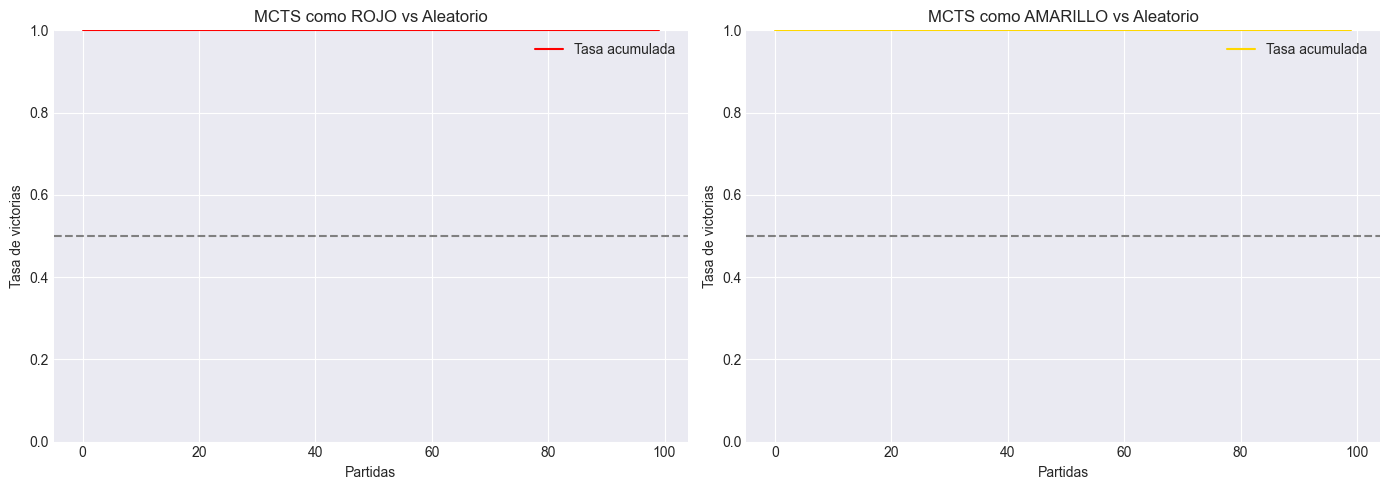

In [8]:
# 6. Curvas acumuladas de victorias a lo largo del torneo (ej. para la primer evaluación)
def cumulative_rate_from_winners(winners, agent_player_value):
    cumulative = []
    wins = 0
    for i, w in enumerate(winners, 1):
        if w == agent_player_value:
            wins += 1
        cumulative.append(wins / i)
    return cumulative

cum_red = cumulative_rate_from_winners(results_red['winners'], -1)
cum_yellow = cumulative_rate_from_winners(results_yellow['winners'], 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(cum_red, color='red', label='Tasa acumulada')
axes[0].axhline(0.5, color='gray', linestyle='--')
axes[0].set_title('MCTS como ROJO vs Aleatorio')
axes[0].set_xlabel('Partidas')
axes[0].set_ylabel('Tasa de victorias')
axes[0].set_ylim(0,1)
axes[0].legend()

axes[1].plot(cum_yellow, color='gold', label='Tasa acumulada')
axes[1].axhline(0.5, color='gray', linestyle='--')
axes[1].set_title('MCTS como AMARILLO vs Aleatorio')
axes[1].set_xlabel('Partidas')
axes[1].set_ylabel('Tasa de victorias')
axes[1].set_ylim(0,1)
axes[1].legend()

plt.tight_layout()
plt.show()

---

## 7 — Estadísticas de tiempo de decisión


MCTS (Red) vs Random:
  Player1 (rojo) - mean: 1.10198s, median: 0.96115s, max: 3.25904s
  Player2 (amarillo) - mean: 0.00003s, median: 0.00002s, max: 0.00022s

Random vs MCTS (Yellow):
  Player1 (rojo) - mean: 0.00003s, median: 0.00002s, max: 0.00062s
  Player2 (amarillo) - mean: 0.96990s, median: 0.97195s, max: 2.10952s


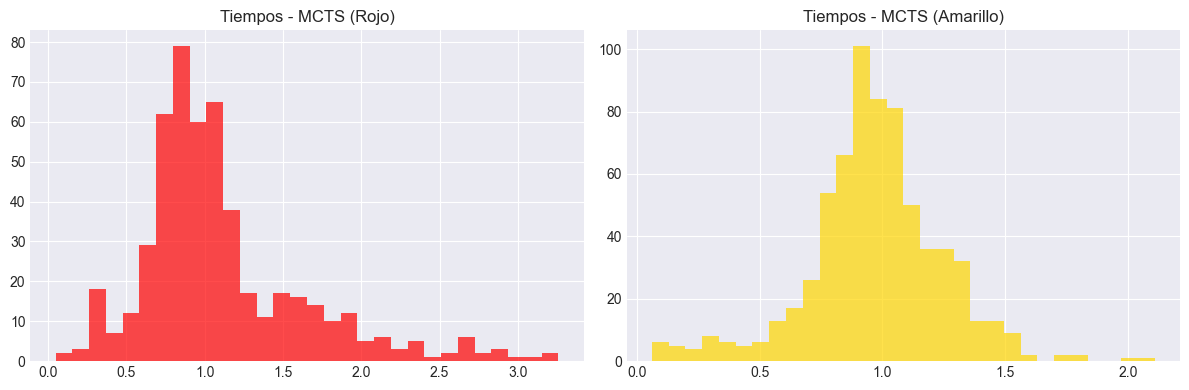

In [9]:
# 7. Estadísticas de tiempos de decisión
import numpy as np

def print_time_stats(results, label):
    times_p1 = np.array(results['times_p1']) if results['times_p1'] else np.array([0.0])
    times_p2 = np.array(results['times_p2']) if results['times_p2'] else np.array([0.0])
    print(f"\n{label}:")
    print(f"  Player1 (rojo) - mean: {times_p1.mean():.5f}s, median: {np.median(times_p1):.5f}s, max: {times_p1.max():.5f}s")
    print(f"  Player2 (amarillo) - mean: {times_p2.mean():.5f}s, median: {np.median(times_p2):.5f}s, max: {times_p2.max():.5f}s")

print_time_stats(results_red, "MCTS (Red) vs Random")
print_time_stats(results_yellow, "Random vs MCTS (Yellow)")

# Histograma comparativo
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(results_red['times_p1'], bins=30, color='red', alpha=0.7)
axes[0].set_title('Tiempos - MCTS (Rojo)')
axes[1].hist(results_yellow['times_p2'], bins=30, color='gold', alpha=0.7)
axes[1].set_title('Tiempos - MCTS (Amarillo)')
plt.tight_layout()
plt.show()

---

## 8 — Múltiples experimentos y medias (opcional, puede tardar)

Este bloque ejecuta varios experimentos (cada uno con N partidas) para promediar curvas y obtener desviación estándar. Reduce `NUM_EXPERIMENTS` y `GAMES_PER_EXPERIMENT` si tienes límite de tiempo.


Experiment 1/3 ...


Exp1-Yellow: 100%|██████████| 50/50 [04:16<00:00,  5.14s/it]




Experiment 2/3 ...


Exp2-Yellow: 100%|██████████| 50/50 [05:54<00:00,  7.10s/it]




Experiment 3/3 ...


Exp3-Yellow: 100%|██████████| 50/50 [04:06<00:00,  4.93s/it]



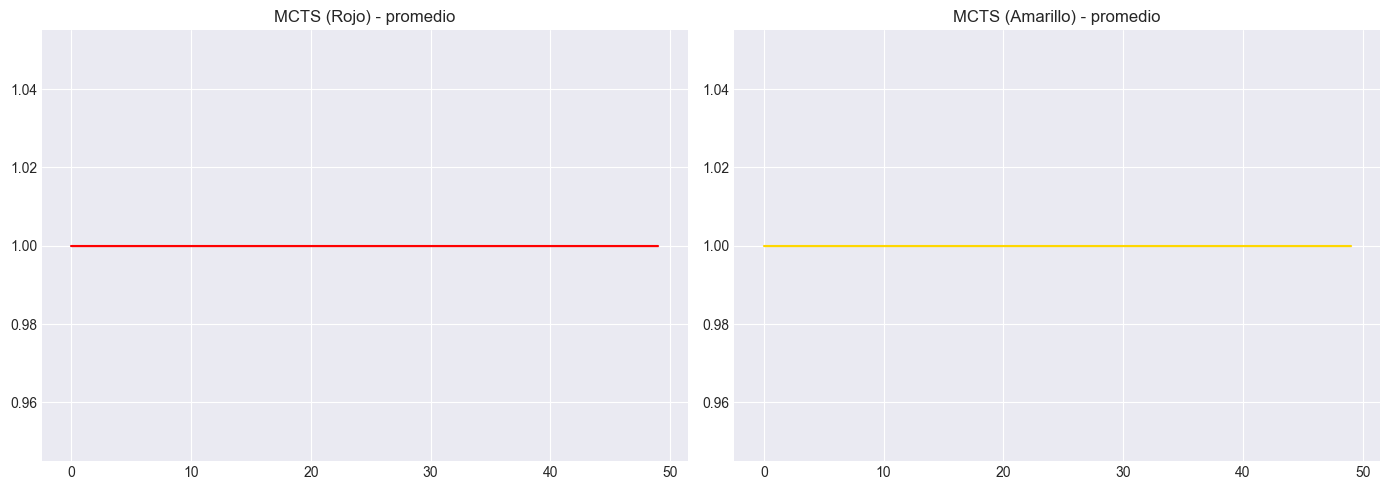


Final mean win rate (Red): 100.00% ± 0.00%
Final mean win rate (Yellow): 100.00% ± 0.00%


In [10]:
# 8. Múltiples experimentos
NUM_EXPERIMENTS = 3
GAMES_PER_EXPERIMENT = 50

all_rates_red = []
all_rates_yellow = []

for exp in range(NUM_EXPERIMENTS):
    print(f"\nExperiment {exp+1}/{NUM_EXPERIMENTS} ...")
    mcts_red = MCTSPolicy()
    mcts_red.mount()
    rnd = RandomPolicy()
    rnd.mount()
    res = run_tournament(mcts_red, rnd, GAMES_PER_EXPERIMENT, desc=f"Exp{exp+1}-Red")
    rates_red = cumulative_rate_from_winners(res['winners'], -1)
    all_rates_red.append(rates_red)

    mcts_y = MCTSPolicy()
    mcts_y.mount()
    rnd2 = RandomPolicy()
    rnd2.mount()
    res2 = run_tournament(rnd2, mcts_y, GAMES_PER_EXPERIMENT, desc=f"Exp{exp+1}-Yellow")
    rates_y = cumulative_rate_from_winners(res2['winners'], 1)
    all_rates_yellow.append(rates_y)

all_rates_red = np.array(all_rates_red)
all_rates_yellow = np.array(all_rates_yellow)

mean_red = np.mean(all_rates_red, axis=0)
std_red = np.std(all_rates_red, axis=0)
mean_yellow = np.mean(all_rates_yellow, axis=0)
std_yellow = np.std(all_rates_yellow, axis=0)

# Plot with confidence bands
x = np.arange(GAMES_PER_EXPERIMENT)
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].plot(x, mean_red, color='red', label='mean')
axes[0].fill_between(x, mean_red-std_red, mean_red+std_red, color='red', alpha=0.3)
axes[0].set_title('MCTS (Rojo) - promedio')
axes[1].plot(x, mean_yellow, color='gold', label='mean')
axes[1].fill_between(x, mean_yellow-std_yellow, mean_yellow+std_yellow, color='gold', alpha=0.3)
axes[1].set_title('MCTS (Amarillo) - promedio')
plt.tight_layout()
plt.show()

print(f"\nFinal mean win rate (Red): {mean_red[-1]:.2%} ± {std_red[-1]:.2%}")
print(f"Final mean win rate (Yellow): {mean_yellow[-1]:.2%} ± {std_yellow[-1]:.2%}")

---

## 9 — Análisis de primeros movimientos y preferencias

Collect moves: 100%|██████████| 100/100 [34:19<00:00, 20.60s/it]



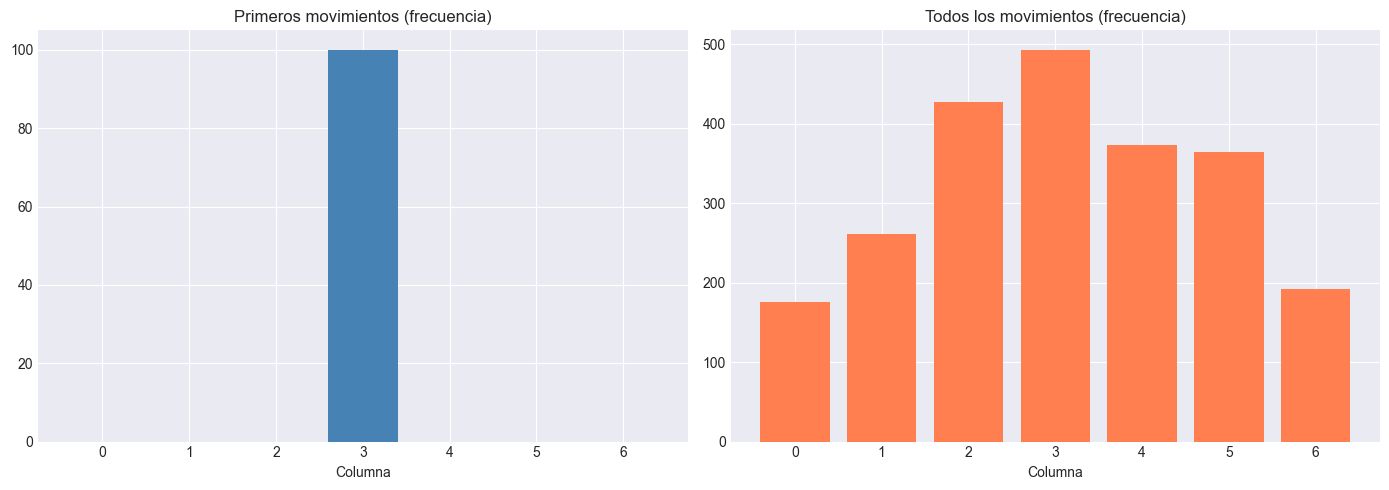

In [11]:
# 9. Recolectar y visualizar primero movimientos
def collect_move_statistics(policy, num_games=100):
    first_moves = []
    all_moves = []
    for _ in tqdm(range(num_games), desc="Collect moves"):
        state = ConnectState()
        move_count = 0
        while not state.is_final() and move_count < 42:
            action = policy.act(state.board)
            if move_count == 0:
                first_moves.append(action)
            all_moves.append(action)
            # validar acción
            if not state.is_applicable(action):
                # saltar (o elegir aleatorio como fallback)
                avail = [c for c in range(state.COLS) if state.is_col_free(c)]
                if not avail:
                    break
                action = int(np.random.choice(avail))
            state = state.transition(action)
            move_count += 1
    return first_moves, all_moves

mcts_fresh = MCTSPolicy()
mcts_fresh.mount()
first_moves, all_moves = collect_move_statistics(mcts_fresh, num_games=100)

# Visualización
fig, axes = plt.subplots(1,2, figsize=(14,5))
first_counts = np.bincount(np.array(first_moves), minlength=7)
axes[0].bar(range(7), first_counts, color='steelblue')
axes[0].set_title('Primeros movimientos (frecuencia)')
axes[0].set_xlabel('Columna')

all_counts = np.bincount(np.array(all_moves), minlength=7)
axes[1].bar(range(7), all_counts, color='coral')
axes[1].set_title('Todos los movimientos (frecuencia)')
axes[1].set_xlabel('Columna')

plt.tight_layout()
plt.show()

---

## 10 — Guardar resultados y gráficos

In [12]:
# 10. Guardar gráficas y resultados resumen
plt.savefig("mcts_evaluation_summary.png", dpi=300, bbox_inches="tight")
print("Saved summary plot to mcts_evaluation_summary.png")

# También guardar csv con resumen de resultados si se desea
summary = {
    "mcts_red_wins": results_red['wins_p1'],
    "mcts_red_losses": results_red['wins_p2'],
    "mcts_red_draws": results_red['draws'],
    "mcts_yellow_wins": results_yellow['wins_p2'],
    "mcts_yellow_losses": results_yellow['wins_p1'],
    "mcts_yellow_draws": results_yellow['draws']
}
pd.DataFrame([summary]).to_csv("mcts_evaluation_summary.csv", index=False)
print("Saved summary CSV to mcts_evaluation_summary.csv")

Saved summary plot to mcts_evaluation_summary.png
Saved summary CSV to mcts_evaluation_summary.csv


<Figure size 640x480 with 0 Axes>